<a href="https://colab.research.google.com/github/natehorner/learn_pt_02/blob/main/pt_vision_functionalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#functionize the setup - make a setup block, a training function, and a evaluation function



In [2]:
#once per session

!pip install torchmetrics


#includes
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import torchmetrics
from torchmetrics import Accuracy

from torch.utils.data import DataLoader

import tqdm
from tqdm.auto import tqdm
from timeit import default_timer as timer

print(torch.__version__)
print(torchvision.__version__)

train_data = datasets.FashionMNIST(
    root="data",#destination directory
    train=True, #training, not test
    download=True, #download yes
    transform=ToTensor(), #how output should be handled
    target_transform=None #how lables/targets should be handled
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.6 MB/s eta 0:00:00
2.1.0+cu118
0.16.0+cu118


100%|██████████| 26421880/26421880 [00:01<00:00, 21347547.83it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 344512.98it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6217855.83it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4430093.76it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
#device hyper parameters, run rarely

SEED_BASE = int("BADBEEF",16)
IN_FEAT = 28*28 #based on input data
class_names = train_data.classes
OUT_CLASSES = len(class_names)  #based on # of output classes in data
BATCH_SIZE = 32
HIDDEN_UNIT_DEF = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

if(device == "cpu"):
  torch.manual_seed(SEED_BASE)
else:torch.cuda.manual_seed(SEED_BASE)

In [4]:
#data and global resource setup

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) #shuffle makes it so that ordered
                                            # data sets don't matter



test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)



In [5]:
#class and function definitions

#define fashion model
class FashionMNISTModel1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),#flatten the 28x28 input to a vector
      nn.Linear(in_features=input_shape,  out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU()
    )

  def forward(self,x):
    return self.layer_stack(x)

torch.manual_seed(SEED_BASE)
model_fashion = FashionMNISTModel1(input_shape=IN_FEAT,
                                   hidden_units = HIDDEN_UNIT_DEF,
                                   output_shape=OUT_CLASSES
                                   ).to(device)

def training_step(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  opt: torch.optim.Optimizer,
                  acc_fn,
                  device: torch.device = device):

  model.train()
  train_loss = 0
  train_acc = 0

  #loop through each batch in data_loader
  for batch, (X_trd,y_trd) in enumerate(data_loader):

    #move data to device
    X_trd = X_trd.to(device)
    y_trd = y_trd.to(device)

    #forward pass - make predictions
    y_trp = model(X_trd)

    #calculate loss per batch
    train_batch_loss = loss_fn(y_trp,y_trd)
    train_loss += train_batch_loss

    train_acc += acc_fn(y_trp.argmax(dim=1),y_trd)

    #zero gradient the optimizer
    opt.zero_grad()


    #calculate model update
    train_batch_loss.backward()

    #step the optimizer, update the model
    opt.step()
  #end of batch enumeration

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)

  print(f"Train loss: {train_loss:.5f}  ::: Train Acc: {train_acc:.2f}")

#end def training_step


def test_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn,
               device: torch.device = device):
  """Returns a dictionary containing results of model predicting data loader"""
  loss = 0
  acc = 0

  model.eval()
  with torch.inference_mode():
    for X_ted,y_ted in tqdm(data_loader):

      X_ted = X_ted.to(device)
      y_ted = y_ted.to(device)

      #make prediction
      y_tep = model(X_ted)

      #accumulate loss
      loss += loss_fn(y_tep,y_ted)
      acc += acc_fn(y_tep.argmax(dim=1),y_ted)
    #end batch loop

  #end inference_mode

  #scale loss and acc to be per batch
  loss = loss/len(data_loader)
  acc = acc/len(data_loader)


  print(f"Test loss: {loss:.5f}  ::: Test Acc: {acc:.2f}")

  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

#end eval_model()

In [6]:


#create a baseline model using the training/testing functions

#model specific params
EPOCHS = 3
HIDDEN_UNITS = 10


model_fashion_1 = FashionMNISTModel1(input_shape = IN_FEAT,
                                     hidden_units = HIDDEN_UNITS,
                                     output_shape = OUT_CLASSES).to(device)

m1_loss_fn = nn.CrossEntropyLoss()
m1_opt = torch.optim.SGD(params=model_fashion_1.parameters(),lr = .1)
m1_acc_fn = Accuracy(task="MULTICLASS",num_classes=OUT_CLASSES).to(device)

for epoch in tqdm(range(EPOCHS)):
  print(f"Starting Epoch {epoch}\n-----------\n")
  training_step(model = model_fashion_1,
                data_loader = train_dataloader,
                loss_fn = m1_loss_fn,
                opt = m1_opt,
                acc_fn = m1_acc_fn)
  test_model(model=model_fashion_1,
             data_loader = test_dataloader,
             loss_fn = m1_loss_fn,
             acc_fn = m1_acc_fn)
#end epoch loop



  0%|          | 0/3 [00:00<?, ?it/s]

Starting Epoch 0
-----------

Train loss: 0.98275  ::: Train Acc: 0.69


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.85162  ::: Test Acc: 0.72
Starting Epoch 1
-----------

Train loss: 0.82791  ::: Train Acc: 0.73


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.80885  ::: Test Acc: 0.73
Starting Epoch 2
-----------

Train loss: 0.80139  ::: Train Acc: 0.73


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.82096  ::: Test Acc: 0.73


In [14]:
#create a Convolution Neural Network
# input -> convultional layer -> ReLU layer (activation) -> pooling layer
# (opt next layer) -> convolutional layer -> ReLU layer -> pooling layer
# -> linear output layer

#convolution layer applies a kernel (a small matrix) over the image,
# like a filter, and produces an output that can be same-ish size as input

#replicate the Tiny VGG network on https://poloclub.github.io/cnn-explainer/
#kernel size - 3 means 3x3, can take a tuple as well
#stride - step in input between kernel frames.  2 means every other pixel
#padding - added stuff around the border

FLATTEN_OUTPUT = 7*7 #28x28 pixel input, compressed down to 14x14 from first
# conv block, then 7x7 from second conv block.  Conv2d documentation has formula
class model_fashion_conv0(nn.Module):

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,
                  kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,
                  kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,
                  kernel_size = 3,stride = 1,padding =1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,
                  kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(kernel_size=2)
    )
    self.class_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)
    )
  #end def __init__()

  def forward(self,x):
    #print(x.shape)
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.class_layer(x)
    #print(x.shape)
    return x

  #end def forward()

#end model_fashion_conv0 definition




In [23]:
#create a cnv. neural network

#model specific params
EPOCHS = 1
HIDDEN_UNITS = 10
IN_CHANNELS = 1 #channels! because first input is greyscale
class_names = train_data.classes
OUT_CLASSES = len(class_names)

model_fashion_2 = model_fashion_conv0(input_shape = IN_CHANNELS, #channels! greyscale
                                     hidden_units = HIDDEN_UNITS,
                                     output_shape = OUT_CLASSES).to(device)


#model shape debug below (generate random image input to check the shape works)

#train and test model using functions above
m2_loss_fn = nn.CrossEntropyLoss()
m2_opt = torch.optim.SGD(params=model_fashion_2.parameters(),lr = .1)
m2_acc_fn = Accuracy(task="MULTICLASS",num_classes=OUT_CLASSES).to(device)

for epoch in tqdm(range(EPOCHS)):
  print(f"Starting Epoch {epoch}\n-----------\n")
  training_step(model = model_fashion_2,
                data_loader = train_dataloader,
                loss_fn = m2_loss_fn,
                opt = m2_opt,
                acc_fn = m2_acc_fn)
  test_model(model=model_fashion_2,
             data_loader = test_dataloader,
             loss_fn = m2_loss_fn,
             acc_fn = m2_acc_fn)
#end epoch loop



  0%|          | 0/1 [00:00<?, ?it/s]

Starting Epoch 0
-----------

Train loss: 0.56884  ::: Train Acc: 0.79


  0%|          | 0/313 [00:00<?, ?it/s]

Test loss: 0.37589  ::: Test Acc: 0.87


torch.Size([1, 28, 28])
torch.Size([1, 10])
tensor([[ 3.1407,  0.9924, -0.1469,  3.7049,  0.3092, -5.4857,  1.1469, -1.2435,
         -1.7315, -2.3473]], grad_fn=<AddmmBackward0>)
tensor([[3.1934e-01, 3.7258e-02, 1.1925e-02, 5.6137e-01, 1.8817e-02, 5.7256e-05,
         4.3485e-02, 3.9829e-03, 2.4449e-03, 1.3207e-03]],
       grad_fn=<SoftmaxBackward0>)
Identified Item:Dress, confidence = 56.1%
item index: tensor([3])


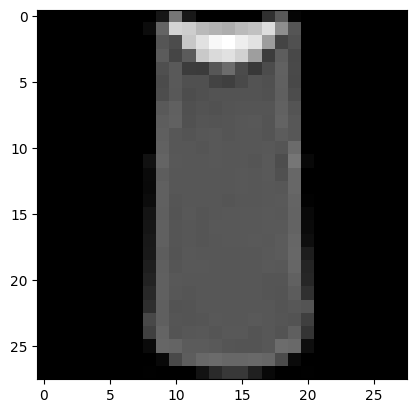

In [54]:
#debug
#use item through model manually
INDEX = 2


idx = INDEX % len(train_data)

img,label = train_data[idx]
print(img.shape)
plt.imshow(img.squeeze(),cmap="gray")
pred = model_fashion_2(img.unsqueeze(dim=0))
print(pred.shape)
print(pred)

pred_prb = torch.softmax(pred,dim=1)
pred_lbl = torch.argmax(pred_prb,dim=1)

print(pred_prb)
print(f"Identified Item:{class_names[pred_lbl]}, confidence = {100*max(pred_prb.squeeze()):.1f}%")
print(f"item index: {pred_lbl}")

In [60]:
seed_ctr = 0

torch.Size([1, 28, 28])
torch.Size([1, 10])
tensor([[ -1.9016,  10.4142,  -3.0753,   1.7075,   9.3804,  -8.7621,   5.1266,
         -14.1709,   1.5735, -12.3782]], grad_fn=<AddmmBackward0>)
tensor([[3.2921e-06, 7.3473e-01, 1.0180e-06, 1.2158e-04, 2.6132e-01, 3.4511e-09,
         3.7134e-03, 1.5452e-11, 1.0633e-04, 9.2798e-11]],
       grad_fn=<SoftmaxBackward0>)
Identified Item:Trouser, confidence = 73.5%
item index: tensor([1])


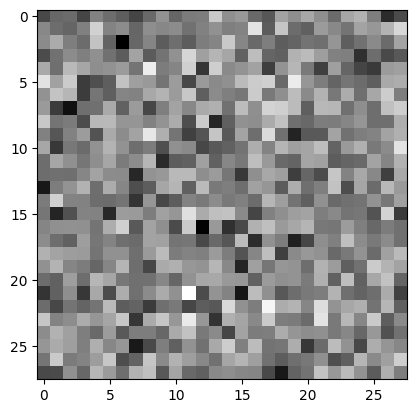

In [63]:
#debug random noise
#create simple input to get model shapes working/debugged
torch.manual_seed(seed_ctr)
seed_ctr+= 1
randinput=torch.randn(size=(1,1,28,28))
img = randinput[0]
print(img.shape)
plt.imshow(img.squeeze(),cmap="gray")
pred = model_fashion_2(randinput)
print(pred.shape)
print(pred)

pred_prb = torch.softmax(pred,dim=1)
pred_lbl = torch.argmax(pred_prb,dim=1)

print(pred_prb)
print(f"Identified Item:{class_names[pred_lbl]}, confidence = {100*max(pred_prb.squeeze()):.1f}%")
print(f"item index: {pred_lbl}")